In [1]:
%matplotlib inline
import cv2

import matplotlib
import pylab as plt
import numpy as np
import math
import tensorflow as tf

from numpy import ma
from tensorflow.keras.models import load_model
from models.mobilenet_model import get_mobilenet_model
from scipy.ndimage.filters import gaussian_filter

## Create keras model and load weights

In [2]:
weights_path = "weights.best.mobilenet.h5" # weights tarined from scratch 

model = get_mobilenet_model(1.0, 224)
model.load_weights(weights_path)

## Load a sample image

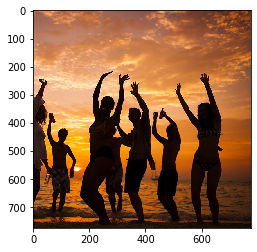

In [3]:
path = 'new.jpg'
oriImg = cv2.imread(path) # B,G,R order
oldImg = oriImg
oldImg_h, oldImg_w, _ = oldImg.shape
plt.imshow(oriImg[:,:,[2,1,0]])

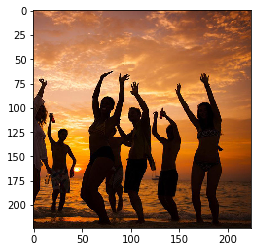

In [4]:
oriImg = cv2.resize(oriImg, dsize=(224, 224), interpolation=cv2.INTER_CUBIC) ##
plt.imshow(oriImg[:,:,[2,1,0]])

## Heatmaps

Input shape: (1, 224, 224, 3)
PAF shape: (1, 28, 28, 38)
Heatmap shape: (1, 28, 28, 19)


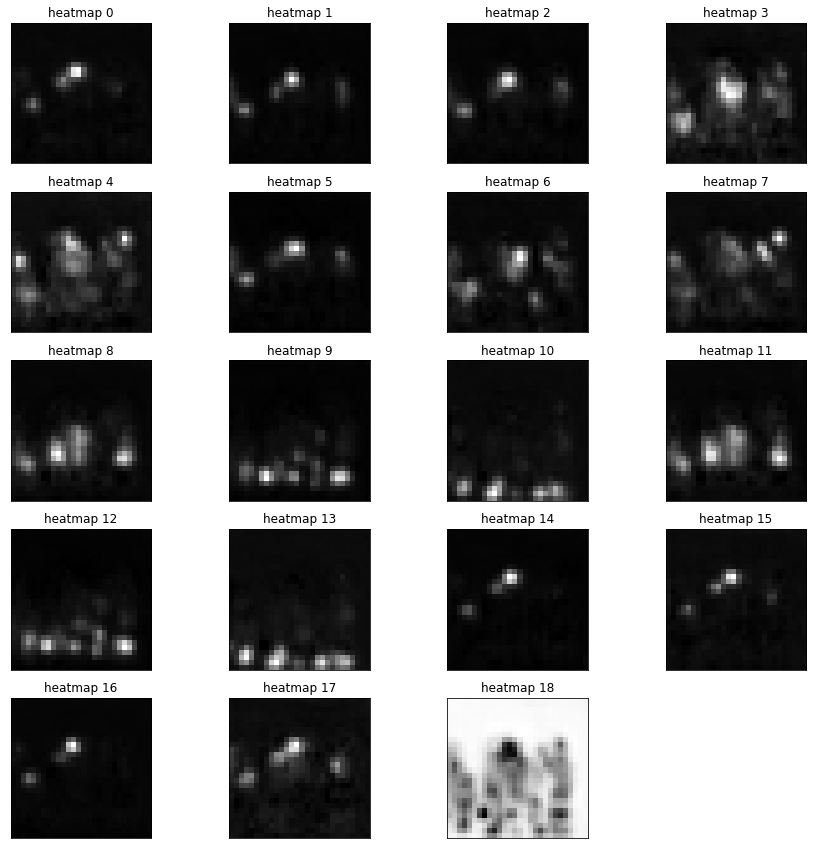

In [5]:
#input_img = np.transpose(np.float32(imageToTest_padded[:,:,:,np.newaxis]), (3,0,1,2)) # required shape (1, width, height, channels) 
input_img = oriImg[np.newaxis,...] 
print("Input shape: " + str(input_img.shape))  
output_blobs = model.predict(input_img)
paf = output_blobs[2]
heatmap = output_blobs[3]
print("PAF shape: " + str(paf.shape))
print("Heatmap shape: " + str(heatmap.shape))

heatmap = heatmap[0]
paf = paf[0]

figure = plt.figure(figsize=(15, 15))

for i in range(19):

    plt.subplot(5, 4, i+1, title='heatmap {}'.format(i))
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(heatmap[:, :, i], cmap='gray')


## Image + heatmap

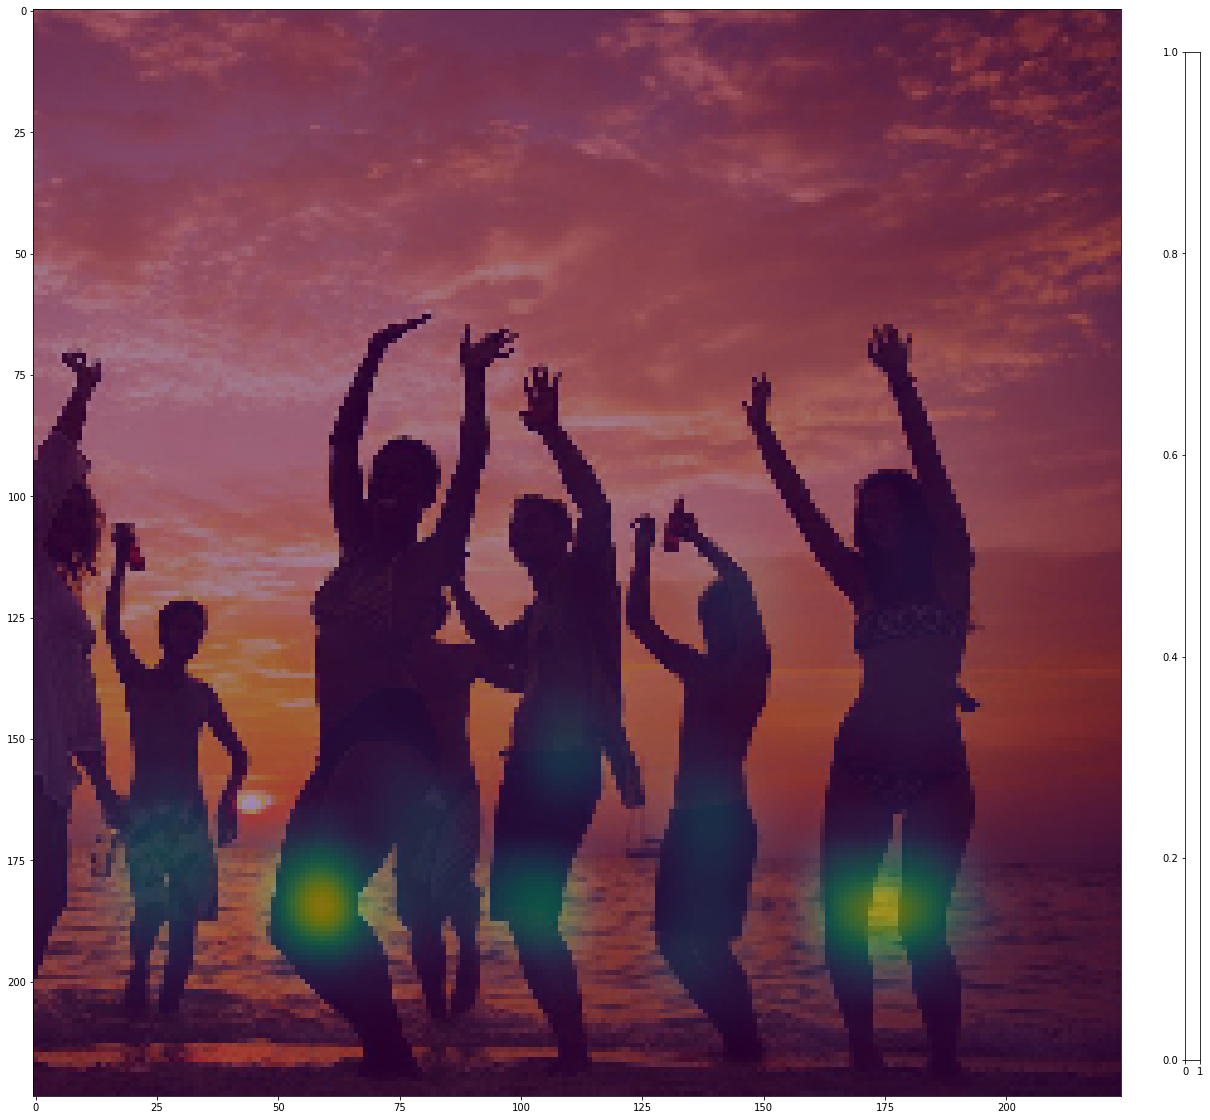

In [6]:
plt.imshow(oriImg[:,:,[2,1,0]])
h = cv2.resize(heatmap[:,:,9], (0,0), fx=8, fy=8, interpolation=cv2.INTER_CUBIC)

plt.imshow(h, alpha=.5)

fig = matplotlib.pyplot.gcf()
cax = matplotlib.pyplot.gca()
fig.set_size_inches(20, 20)
fig.subplots_adjust(right=0.93)
cbar_ax = fig.add_axes([0.95, 0.15, 0.01, 0.7])
#_ = fig.colorbar(ax, cax=cbar_ax)

## Paf vectors 

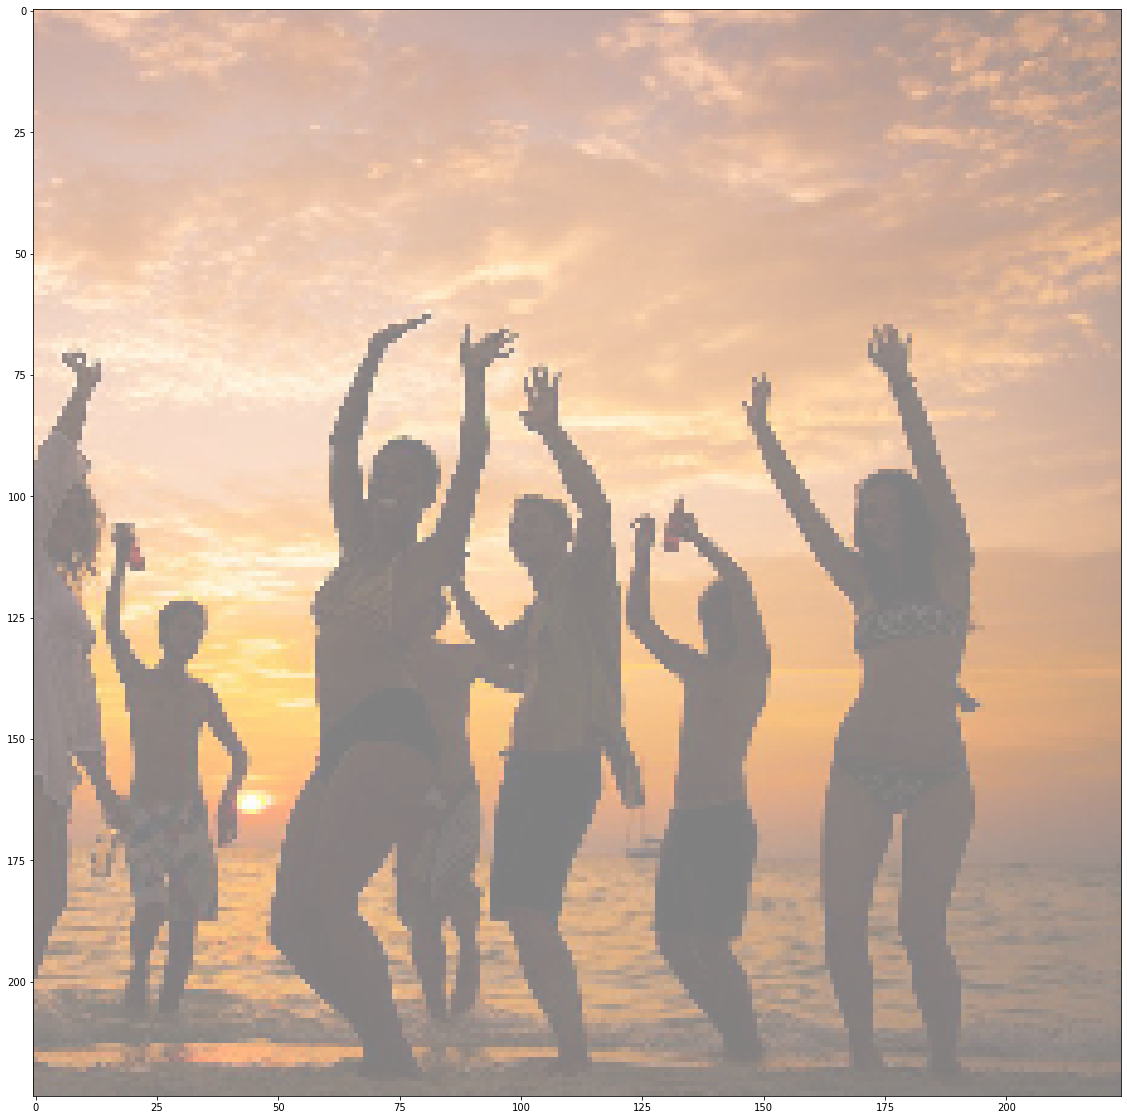

In [7]:
U = paf[:,:,16] * -1
V = paf[:,:,17]
U = cv2.resize(U, (0,0), fx=8, fy=8, interpolation=cv2.INTER_CUBIC)
V = cv2.resize(V, (0,0), fx=8, fy=8, interpolation=cv2.INTER_CUBIC)


X, Y = np.meshgrid(np.arange(U.shape[1]), np.arange(U.shape[0]))
M = np.zeros(U.shape, dtype='bool')
M[U**2 + V**2 < 0.5 * 0.5] = True
U = ma.masked_array(U, mask=M)
V = ma.masked_array(V, mask=M)

# 1
plt.figure()
plt.imshow(oriImg[:,:,[2,1,0]], alpha = .5)
s = 5
Q = plt.quiver(X[::s,::s], Y[::s,::s], U[::s,::s], V[::s,::s], 
               scale=50, headaxislength=4, alpha=.5, width=0.001, color='r')

fig = matplotlib.pyplot.gcf()
fig.set_size_inches(20, 20)

## Visualise all detected body parts. Note that we use peaks in heatmaps

In [8]:
all_peaks = []
peak_counter = 0
thre1 = 0.1

for part in range(18):
    map = heatmap[:,:,part]
    #map = gaussian_filter(map_ori, sigma=3)
    
    map_left = np.zeros(map.shape)
    map_left[1:,:] = map[:-1,:]
    map_right = np.zeros(map.shape)
    map_right[:-1,:] = map[1:,:]
    map_up = np.zeros(map.shape)
    map_up[:,1:] = map[:,:-1]
    map_down = np.zeros(map.shape)
    map_down[:,:-1] = map[:,1:]
    
    peaks_binary = np.logical_and.reduce((map>=map_left, map>=map_right, map>=map_up, map>=map_down, map > thre1))
    peaks = list(zip(np.nonzero(peaks_binary)[1], np.nonzero(peaks_binary)[0])) # note reverse
    peaks_with_score = [x + (map[x[1],x[0]],) for x in peaks]
    id = range(peak_counter, peak_counter + len(peaks))
    peaks_with_score_and_id = [peaks_with_score[i] + (id[i],) for i in range(len(id))]

    all_peaks.append(peaks_with_score_and_id)
    peak_counter += len(peaks)

In [9]:
# find connection in the specified sequence, center 29 is in the position 15
limbSeq = [[2,3], [2,6], [3,4], [4,5], [6,7], [7,8], [2,9], [9,10], \
           [10,11], [2,12], [12,13], [13,14], [2,1], [1,15], [15,17], \
           [1,16], [16,18], [3,17], [6,18]]
# the middle joints heatmap correpondence
mapIdx = [[31,32], [39,40], [33,34], [35,36], [41,42], [43,44], [19,20], [21,22], \
          [23,24], [25,26], [27,28], [29,30], [47,48], [49,50], [53,54], [51,52], \
          [55,56], [37,38], [45,46]]

In [10]:
thre2 = 0.05

connection_all = []
special_k = []
mid_num = 10

for k in range(len(mapIdx)):
    score_mid = paf[:,:,[x-19 for x in mapIdx[k]]]
    candA = all_peaks[limbSeq[k][0]-1]
    candB = all_peaks[limbSeq[k][1]-1]
    nA = len(candA)
    nB = len(candB)
    indexA, indexB = limbSeq[k]
    if(nA != 0 and nB != 0):
        connection_candidate = []
        for i in range(nA):
            for j in range(nB):
                vec = np.subtract(candB[j][:2], candA[i][:2])
                norm = math.sqrt(vec[0]*vec[0] + vec[1]*vec[1])
                # failure case when 2 body parts overlaps
                if norm == 0:
                    continue
                vec = np.divide(vec, norm)
                
                startend = list(zip(np.linspace(candA[i][0], candB[j][0], num=mid_num), \
                               np.linspace(candA[i][1], candB[j][1], num=mid_num)))
                
                vec_x = np.array([score_mid[int(round(startend[I][1])), int(round(startend[I][0])), 0] \
                                  for I in range(len(startend))])
                vec_y = np.array([score_mid[int(round(startend[I][1])), int(round(startend[I][0])), 1] \
                                  for I in range(len(startend))])

                score_midpts = np.multiply(vec_x, vec[0]) + np.multiply(vec_y, vec[1])
                score_with_dist_prior = sum(score_midpts)/len(score_midpts) + min(0.5*oriImg.shape[0]/norm-1, 0)
                criterion1 = len(np.nonzero(score_midpts > thre2)[0]) > 0.8 * len(score_midpts)
                criterion2 = score_with_dist_prior > 0
                if criterion1 and criterion2:
                    connection_candidate.append([i, j, score_with_dist_prior, score_with_dist_prior+candA[i][2]+candB[j][2]])

        connection_candidate = sorted(connection_candidate, key=lambda x: x[2], reverse=True)
        connection = np.zeros((0,5))
        for c in range(len(connection_candidate)):
            i,j,s = connection_candidate[c][0:3]
            if(i not in connection[:,3] and j not in connection[:,4]):
                connection = np.vstack([connection, [candA[i][3], candB[j][3], s, i, j]])
                if(len(connection) >= min(nA, nB)):
                    break

        connection_all.append(connection)
    else:
        special_k.append(k)
        connection_all.append([])

In [11]:
# last number in each row is the total parts number of that person
# the second last number in each row is the score of the overall configuration
subset = -1 * np.ones((0, 20))
candidate = np.array([item for sublist in all_peaks for item in sublist])

for k in range(len(mapIdx)):
    if k not in special_k:
        partAs = connection_all[k][:,0]
        partBs = connection_all[k][:,1]
        indexA, indexB = np.array(limbSeq[k]) - 1

        for i in range(len(connection_all[k])): #= 1:size(temp,1)
            found = 0
            subset_idx = [-1, -1]
            for j in range(len(subset)): #1:size(subset,1):
                if subset[j][indexA] == partAs[i] or subset[j][indexB] == partBs[i]:
                    subset_idx[found] = j
                    found += 1
            
            if found == 1:
                j = subset_idx[0]
                if(subset[j][indexB] != partBs[i]):
                    subset[j][indexB] = partBs[i]
                    subset[j][-1] += 1
                    subset[j][-2] += candidate[partBs[i].astype(int), 2] + connection_all[k][i][2]
            elif found == 2: # if found 2 and disjoint, merge them
                j1, j2 = subset_idx
                print ("found = 2")
                membership = ((subset[j1]>=0).astype(int) + (subset[j2]>=0).astype(int))[:-2]
                if len(np.nonzero(membership == 2)[0]) == 0: #merge
                    subset[j1][:-2] += (subset[j2][:-2] + 1)
                    subset[j1][-2:] += subset[j2][-2:]
                    subset[j1][-2] += connection_all[k][i][2]
                    subset = np.delete(subset, j2, 0)
                else: # as like found == 1
                    subset[j1][indexB] = partBs[i]
                    subset[j1][-1] += 1
                    subset[j1][-2] += candidate[partBs[i].astype(int), 2] + connection_all[k][i][2]

            # if find no partA in the subset, create a new subset
            elif not found and k < 17:
                row = -1 * np.ones(20)
                row[indexA] = partAs[i]
                row[indexB] = partBs[i]
                row[-1] = 2
                row[-2] = sum(candidate[connection_all[k][i,:2].astype(int), 2]) + connection_all[k][i][2]
                subset = np.vstack([subset, row])

In [12]:
# delete some rows of subset which has few parts occur
deleteIdx = [];
for i in range(len(subset)):
    if subset[i][-1] < 4 or subset[i][-2]/subset[i][-1] < 0.4:
        deleteIdx.append(i)
subset = np.delete(subset, deleteIdx, axis=0)

In [13]:
scale = 8

colors = [[255, 0, 0], [255, 85, 0], [255, 170, 0], [255, 255, 0], [170, 255, 0], [85, 255, 0], [0, 255, 0], \
          [0, 255, 85], [0, 255, 170], [0, 255, 255], [0, 170, 255], [0, 85, 255], [0, 0, 255], [85, 0, 255], \
          [170, 0, 255], [255, 0, 255], [255, 0, 170], [255, 0, 85]]
cmap = matplotlib.cm.get_cmap('hsv')

canvas = cv2.imread(path) # B,G,R order
canvas = cv2.resize(oriImg, dsize=(224, 224), interpolation=cv2.INTER_CUBIC) ##



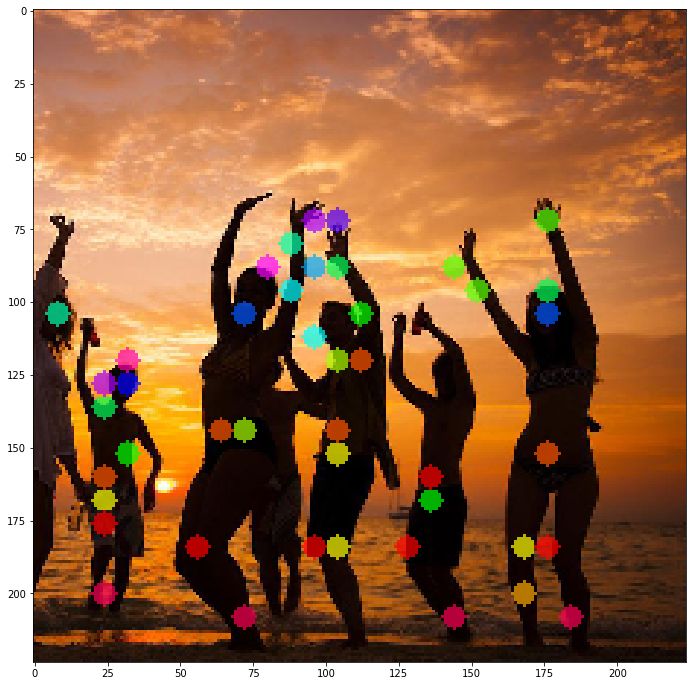

In [14]:
for i in range(18):
    rgba = np.array(cmap(1 - i/18. - 1./36))
    rgba[0:3] *= 255
    for j in range(len(all_peaks[i])):
        x = all_peaks[i][j][0] * scale
        y = all_peaks[i][j][1] * scale
        cv2.circle(canvas, (x, y), 4, colors[i], thickness=-1)

to_plot = cv2.addWeighted(oriImg, 0.3, canvas, 0.7, 0)
plt.imshow(to_plot[:,:,[2,1,0]])
fig = matplotlib.pyplot.gcf()
fig.set_size_inches(12, 12)

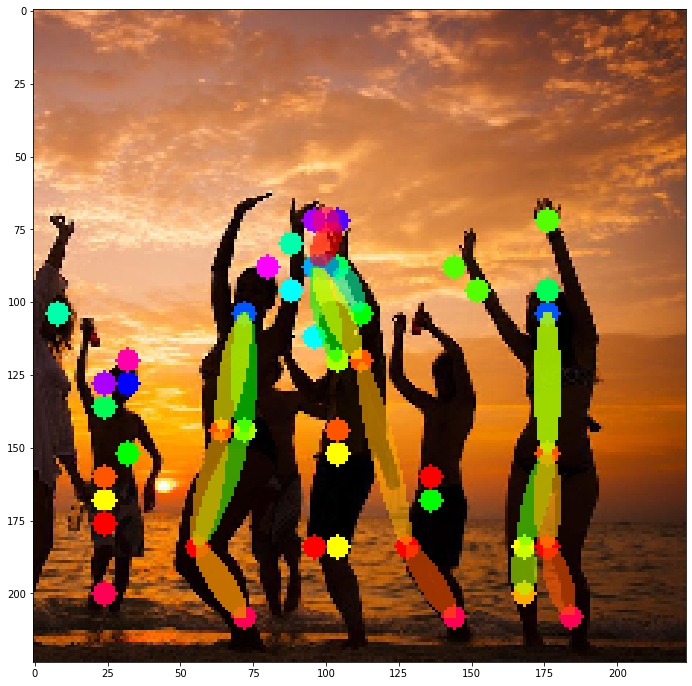

In [15]:
# visualize 2
stickwidth = 4

for i in range(17):
    for n in range(len(subset)):
        index = subset[n][np.array(limbSeq[i])-1]
        if -1 in index:
            continue
        cur_canvas = canvas.copy()
        Y = candidate[index.astype(int), 0] * scale
        X = candidate[index.astype(int), 1] * scale
        mX = np.mean(X)
        mY = np.mean(Y)
        length = ((X[0] - X[1]) ** 2 + (Y[0] - Y[1]) ** 2) ** 0.5
        angle = math.degrees(math.atan2(X[0] - X[1], Y[0] - Y[1]))
        polygon = cv2.ellipse2Poly((int(mY),int(mX)), (int(length/2), stickwidth), int(angle), 0, 360, 1)
        cv2.fillConvexPoly(cur_canvas, polygon, colors[i])
        canvas = cv2.addWeighted(canvas, 0.4, cur_canvas, 0.6, 0)
        
plt.imshow(canvas[:,:,[2,1,0]])
fig = matplotlib.pyplot.gcf()
fig.set_size_inches(12, 12)

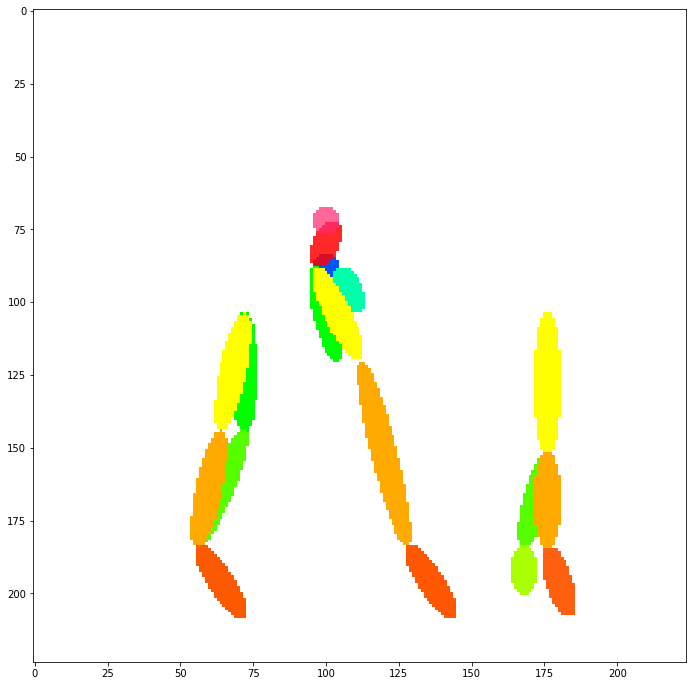

In [16]:
#blank
stickwidth = 4

cur_canvas = np.ones((224,224,3), np.uint8)*255

for i in range(17):
    for n in range(len(subset)):
        index = subset[n][np.array(limbSeq[i])-1]
        if -1 in index:
            continue
        #cur_canvas = canvas.copy()
        Y = candidate[index.astype(int), 0] * scale
        X = candidate[index.astype(int), 1] * scale
        mX = np.mean(X)
        mY = np.mean(Y)
        length = ((X[0] - X[1]) ** 2 + (Y[0] - Y[1]) ** 2) ** 0.5
        angle = math.degrees(math.atan2(X[0] - X[1], Y[0] - Y[1]))
        polygon = cv2.ellipse2Poly((int(mY),int(mX)), (int(length/2), stickwidth), int(angle), 0, 360, 1)
        cv2.fillConvexPoly(cur_canvas, polygon, colors[i])
        canvas = cv2.addWeighted(canvas, 0.4, cur_canvas, 0.6, 0)
        
plt.imshow(canvas[:,:,[2,1,0]])
fig = matplotlib.pyplot.gcf()
fig.set_size_inches(12, 12)

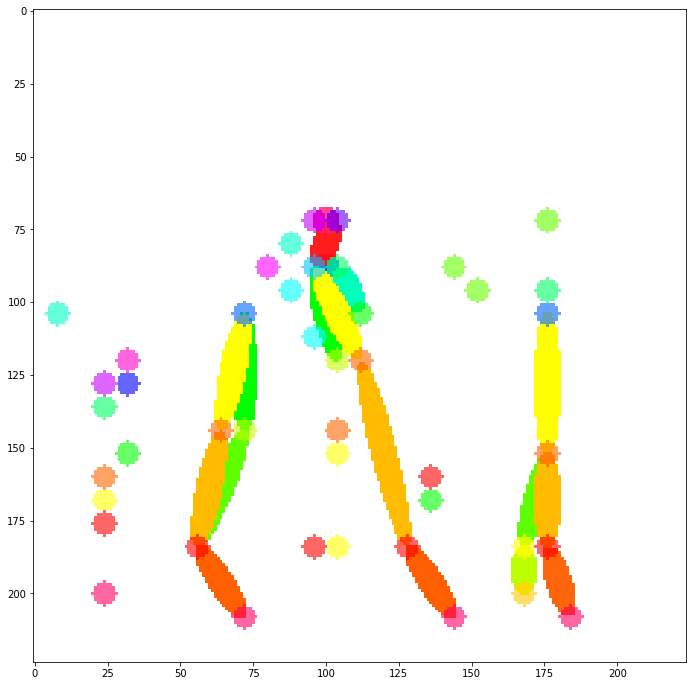

In [17]:
for i in range(18):
    rgba = np.array(cmap(1 - i/18. - 1./36))
    rgba[0:3] *= 255
    for j in range(len(all_peaks[i])):
        x = all_peaks[i][j][0] * scale
        y = all_peaks[i][j][1] * scale
        cv2.circle(canvas, (x, y), 4, colors[i], thickness=-1)

to_plot = cv2.addWeighted(cur_canvas, 0.4, canvas, 0.7, 0)
plt.imshow(to_plot[:,:,[2,1,0]])
fig = matplotlib.pyplot.gcf()
fig.set_size_inches(12, 12)

In [18]:
# overlap
# method 1

"""
# resize back?
scale_percent = 220 # percent of original size
width = int(img.shape[1] * scale_percent / 100)
height = int(img.shape[0] * scale_percent / 100)
dim = (width, height)
# resize image
resized = cv2.resize(img, dim, interpolation = cv2.INTER_AREA)
"""
from PIL import Image
import numpy as np

#resize back
canvas = cv2.resize(canvas, dsize=(oldImg_h, oldImg_w), interpolation=cv2.INTER_AREA) ## improve: record old size
img = Image.fromarray(canvas, 'RGB')
img.save('lines.png')

img = Image.open("lines.png")  # 读取照片
oldimg = Image.open(path)
img = img.convert("RGBA")    # 转换格式，确保像素包含alpha通道
width, height = img.size     # 长度和宽度
for i in range(0,width):     # 遍历所有长度的点
    for j in range(0,height):       # 遍历所有宽度的点
        data = img.getpixel((i,j))  # 获取一个像素
        if (data.count(255) == 4):  # RGBA都是255，改成透明色
            img.putpixel((i,j),oldimg.getpixel((i,j)))

type(img)
img.save('output.png')

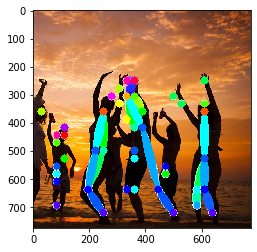

In [21]:
output = cv2.imread('output.png')
plt.imshow(output[:,:,[2,1,0]])

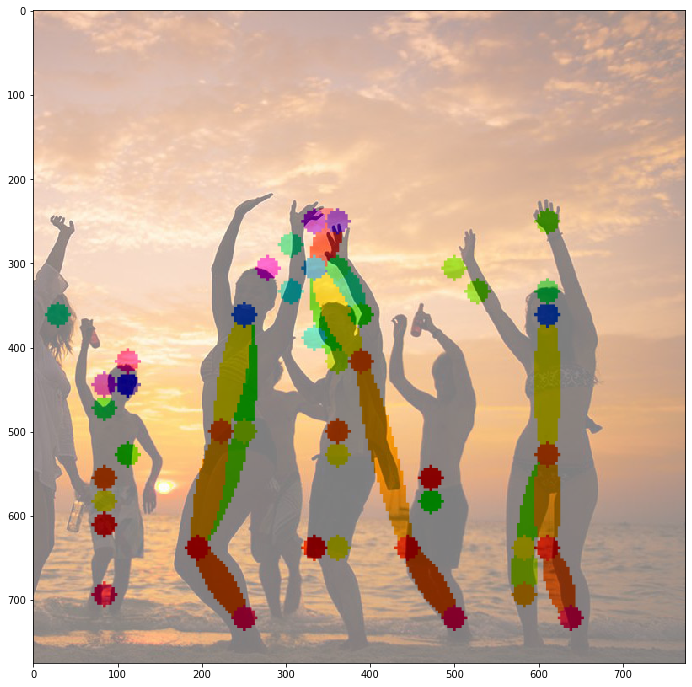

In [22]:
# method 2

#alpha_channel = img.getchannel('A')

plt.imshow(oldImg[:,:,[2,1,0]]) ##
plt.imshow(canvas[:,:,[2,1,0]], alpha = 0.5) ##

fig = matplotlib.pyplot.gcf()
fig.set_size_inches(12, 12)
img.save('output2.png')